# NYC Traffic Speed Map

This code explores the NYC traffic speed data which are collected multiple times a day. My project proposal is to make an app for NYC street parking. Given the current location, the app will display streets near you on which you can street park, and the cost associated with it. I think an interesting thing to add to the project is to also give recommendation on where to park given the crowdedness of the street (as proxied by the traffic speed). The point of this plot is to explore the 7.2GB NYC traffic speed data to see if that can be used to enhance the app. 

## Read in the data and compute the average speed for a given path

In [361]:
import numpy as np
import pandas as pd


# Read in the traffic speed data. It needs to be processed in chunks due to its huge size (7.2GB)
# For the purpose of this preliminary analysis, I will only use speed data for 2018-10-15
# I read over the entire data (because data is not sorted) and only extract out the needed data 
filename = "DOT_Traffic_Speeds_NBE.csv"
chunksize = 100000
i = 1
df20181015 = []
for df in pd.read_csv(filename, chunksize=chunksize, iterator=True):
    #print("Reading in lines ", (i-1)*chunksize, "to ", i*chunksize); i += 1
    temp = df.loc[df["DATA_AS_OF"].str[0:10]=="10/15/2018"]
    if not temp.empty:
        df20181015.append(temp)
        #print("The data for 2018-10-15 is in this slice")

In [363]:
### Concatenate the data frames into one, compute average speed for the day and categorize them
df = pd.concat(df20181015, ignore_index=True)
df = df.reset_index(drop=True)
linkAvgSpeed = df.groupby("LINK_POINTS").agg({"SPEED": np.mean})
linkAvgSpeed["category"] = pd.cut(linkAvgSpeed["SPEED"], 5, labels = ["0-12", "12-25", "25-37", "37-50", "50-65"])
linkAvgSpeed = linkAvgSpeed.reset_index(drop = False)

## Create Shape and Map Objects for the Plot
The input data is in CSV format with longitude and latitude coordinates given as a string. I convert the string to a Shapeley MultiLine object. Then I import a NYC map (GeoJSON format), and superimpose the path traffic speed data on NYC map.  

In [358]:
# Create multiline objects
import geopandas as gp
from shapely.geometry import Point, LineString, shape, MultiLineString
import matplotlib.pyplot as plt


In [357]:
# Convert the string of coordinates to a Shapeley MultiLine object
entry = linkAvgSpeed.loc[0,"LINK_POINTS"]
coords = entry.split()
def convertMultLine(entry):
    coords = entry.split()
    multline = []
    for i in range(1,len(coords)-2):
        try:
            y0 = float(coords[i-1].split(",")[0])
            x0 = float(coords[i-1].split(",")[1])
            y1 = float(coords[i].split(",")[0])
            x1 = float(coords[i].split(",")[1])
            if x0 < -74.4 or x1 < -74.4:
                continue
            else:
                multline.append(((x0, y0), (x1, y1)))
        except ValueError:
            #print("Encounter some nonconvertible string, skipping...")
            continue
        except IndexError:
            #print("Only one coordinate is given, skipping...")
            continue
    return multline

linkAvgSpeed["path"] = linkAvgSpeed["LINK_POINTS"].apply(convertMultLine)
linkAvgSpeed["cameraPath"] = linkAvgSpeed["path"].apply(MultiLineString)


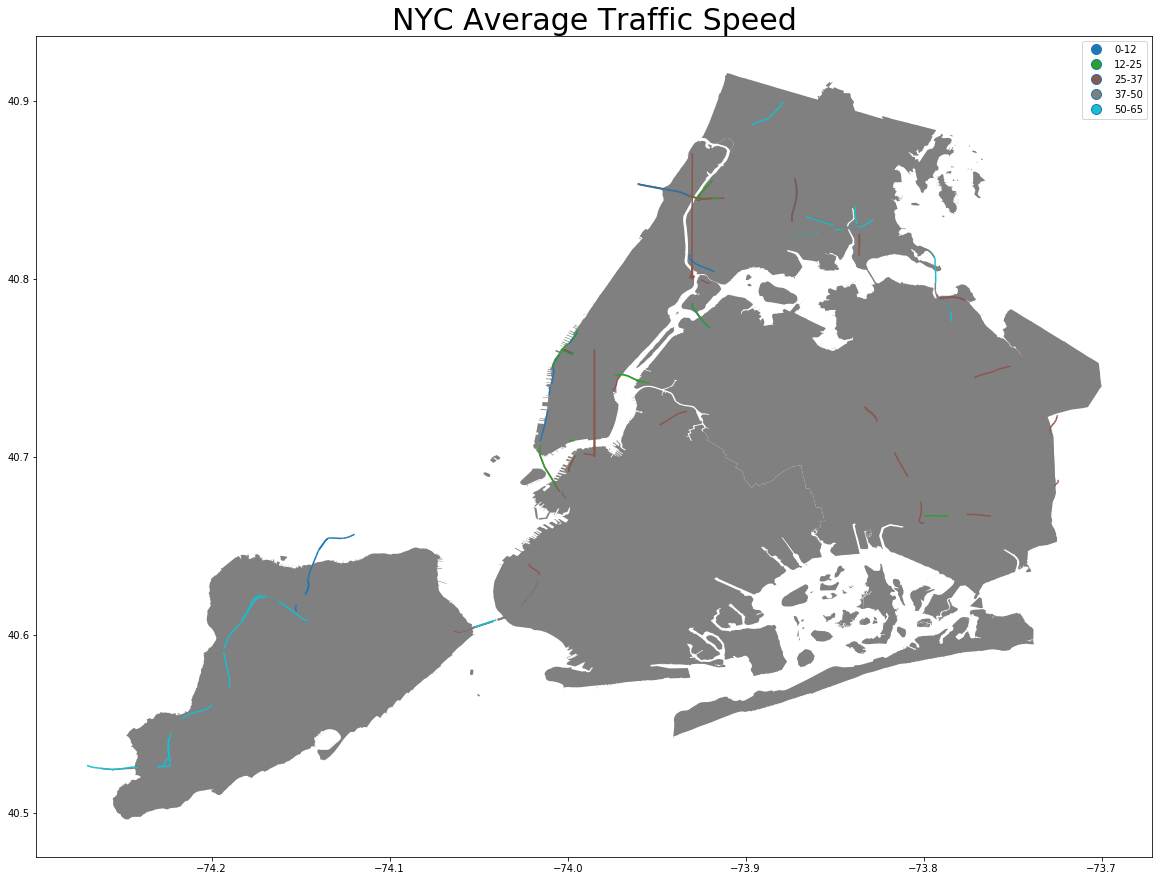

In [227]:
speedGDF = gp.GeoDataFrame(linkAvgSpeed)
speedGDF = speedGDF.set_geometry("cameraPath")
# Read in a NYC Borough map so the lines can be superimposed on top
nycbb = gp.read_file("Borough Boundaries.geojson")

f, ax = plt.subplots(1, figsize=(20, 20))
ax = speedGDF.plot(column='category', ax=ax, legend=True)
nycbb.plot(ax=ax, color="gray")
ax.set_title("NYC Average Traffic Speed", fontsize=30)
plt.show()

Disappointingly, the cameras actually only cover a very small part of the city. So using it to predict whether an particular area will be crowded or not might not be work. However, I think the viability of the app does not depend crucially on this. While this enhancement (how crowded a street is) is nice to have, the app will still work without it. Finally, I can also explore other potential useful data source.    